In [163]:
import wordcloud #分词
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
import numpy as np 
from PIL import Image 

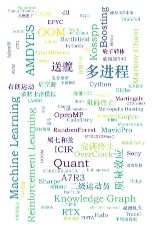

In [167]:
import random
random.seed(0)
# backgroud = np.array(Image.open('test1.jpg')) 
wl = ['RTX']*1550 + ['Cython']*790+['EPYC']*650+['Cupy']*790+['OOM']*2705 + ['dll']*708 + ['AMDYES']*2860 + ['OverClock']*1250
wl += ['Quant']*2800+ ['Sharpe']*761 + ['ICIR']*1568 + ['Trader']*455 + ['Momentum']*358 + ['布朗运动']*915
wl += ['A7R3']*1656 + ['适马']*285 + ['Canon']*286 + ['Kosspp']*2275 + ['sq505']*376 +['Sony']*678 + ['Gopro']*999
wl += ['MavicPro']*958
wl += ['后空翻'] * 789 + ['二级运动员']*1345 +['旋子转体']*626 + ['540后旋']*334 + ['硬拉3倍体重']*326 + ['送髋']*2560
wl += ['卧推100']*500 + ['深蹲150']*450 + ['旋风脚540']*460 + ['起跑反应']*460
wl += ['Halo'] * 750 + ['质量效应']*2280 + ['GhostRecon']*670 + ['CallofDuty']*480 + ['Battlefield']*709 + ['TitanFall']*369
wl += ['Half-Life','BOREDERLANDS','DOOM','GTA','Metro','正当防卫','无人深空'] * 300
wl += ['Machine Learning']*2900 + ['Gibbs']*568 + ['Boosting']*1860 + ['RandomForest']*706 +['Optimization']*256
wl += ['蒙特卡洛模拟']*689 + ['Metropolis-Hasting']*456 + ['OpenMP']*986 + ['Knowledge Graph']*1850 + ['Markov Chain']*1350 
wl += ['Martingale']*569 + ['Reinforcement Learning']*2000
wl += ['多进程']*5000
wl += ['属七和弦']*896 + ['阻碍终止']*996 + ['完满终止']*1456
wl += ['主和弦','属和弦','下属和弦','对位']*250

wl += ['RTX3080','RTX2070MaxQ','GTX1060','10900K','5950X','主板烧了','ddr4','虚拟内存炸了','半精度溢出']*300
wl += ['PyTorch','Adam','AdamW','SGD','FISTA','Nesterov','LASSO','Ridge','线性回归','SVM','Probit','EM','变分推断','平均场近似']*350
wl += ['波动率微笑', '看涨期权', '蝶式期权', 'bull spread', 'Fama French', 'effective spread', '高位放量'] * 300

random.shuffle(wl)
space_list = ' '.join(wl)
backgroud = np.array(Image.open('C:/Users/Administrator/Desktop/crysis.jpg')) 
wc = WordCloud(width=1400, height=2200,
background_color='white',
mode='RGB', 
# mask=backgroud, #添加蒙版，生成指定形状的词云，并且词云图的颜色可从蒙版里提取
max_words=1000,
font_path='C:\Windows\Fonts\STZHONGS.ttf',
max_font_size=150,
relative_scaling=0.5, #设置字体大小与词频的关联程度
random_state=50, 
scale=2, prefer_horizontal=0.8,
).generate(space_list) 


# image_color = ImageColorGenerator(backgroud)#设置生成词云的颜色，如去掉这两行则字体为默认颜色
# wc.recolor(color_func=image_color)

plt.imshow(wc) #显示词云
plt.axis('off') #关闭x,y轴
plt.show()#显示
wc.to_file('C:/Users/Administrator/Desktop/test1_ciyun.jpg')

## 四个主流估计器A股深交所的测试
几个测试点
1. 根据价格分层，看一下不同价格下的估计性能

#### 2022-03-01
1. 统计价格区间
2. 不同价格区间都测试表现

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.append('C:/Users/Administrator/Desktop/Repositories/Low-Frequency-Spread-Estimator')
sys.path.append('C:/Users/Handsome Bad Guy/Desktop/Repositories/Low-Frequency-Spread-Estimator')

from SpreadEstimator.SpreadEstimator import SpreadEstimator
from mytools.AutoTester import AutoTester

from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.linear_model import LinearRegression

In [2]:
se = SpreadEstimator()
univ = ~np.isnan(se.data.data_dic['close'])  # 合法的univ

In [3]:
def get_xy(x,y,univ):
    xx = []
    yy = []
    for i in range(len(x)):
        se = (~np.isnan(x[i])) & univ[i] & (~np.isnan(y[i]))
        if np.sum(se) == 0:
            continue
        xx.append(x[i:i+1, se].T)
        yy.append(y[i,se])
    return np.vstack(xx), np.hstack(yy)

### 全年平均收盘价分布统计

In [8]:
plt.rcParams['font.sans-serif']=['KaiTi']
plt.rcParams['axes.unicode_minus'] = False

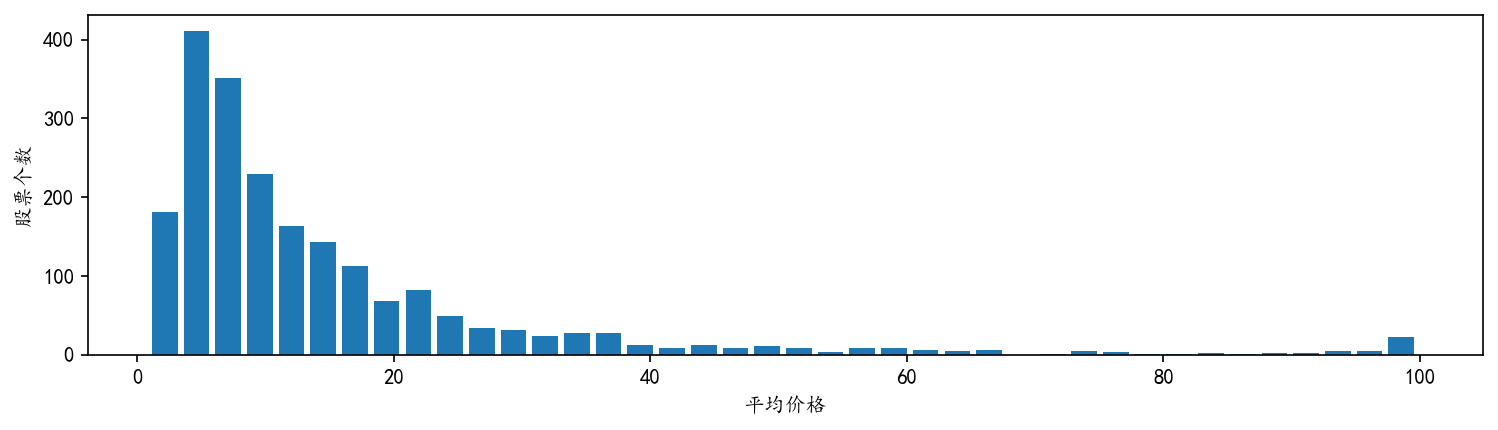

In [15]:
plt.figure(figsize=(12,3), dpi=150)
x = np.nanmean(se.data.data_dic['close'], axis=0)
x[x>100] = 100
plt.hist(x, bins=40, width=2)
plt.xlabel('平均价格')
plt.ylabel('股票个数')
plt.show()

### HL, 2012

In [4]:
print(np.sqrt(2)-1)
print(3-np.sqrt(2)*2)

0.41421356237309515
0.1715728752538097


In [5]:
se.data.spread_dic.keys()

dict_keys(['spread', 'relative_spread', 'vol_wtd_rel_bas', 'vol_wtd_bas'])

In [24]:
lr = LinearRegression()

beta = 'prod{tsmean{powv{minus{logv{high},logv{low}},2},2},2}'

high_1 = 'logv{tsdelay{high,1}}'
low_1 = 'logv{tsdelay{low,1}}'
con_1 = 'condition{gt{logv{low},logv{tsdelay{close,1}}},minus{logv{low},logv{tsdelay{close,1}}},minus{close,close}}'
con_2 = 'condition{lt{logv{high},logv{tsdelay{close,1}}},minus{logv{high},logv{tsdelay{close,1}}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{logv{high},' + con + '}'
low_2 = 'minus{logv{low},' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'



print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


cs_rel_sp
mean corr: -0.1741, positive_corr_ratio: 0.0000, corr_IR: -2.8080
0.001054804254915037



In [40]:
def f(name):
    corr = []
    sig = []
    est = []
    for i in range(20,240):
        sp = np.mean(se.data.spread_dic[name][i-20+1:i+1], axis=0)
        top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)<5)
        # print(np.sum(top))
        sig += list(signal[i,top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread cs 5: {:.4f}'.format(np.nanmean(corr)))
    corr = []
    sig = []
    est = []
    for i in range(20,240):
        sp = np.mean(se.data.spread_dic[name][i-20+1:i+1], axis=0)
        top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>5) &\
        (np.mean(se.data.data_dic['close'][i-19:i],axis=0)<10)
        # print(np.sum(top))
        sig += list(signal[i,top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread cs 5-10: {:.4f}'.format(np.nanmean(corr)))
    for i in range(20,240):
        sp = np.mean(se.data.spread_dic[name][i-20+1:i+1], axis=0)
        top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)<25) & \
        (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>10)
        # print(np.sum(top))
        sig += list(signal[i,top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread cs 10-25: {:.4f}'.format(np.nanmean(corr)))
    corr = []
    sig = []
    est = []
    for i in range(20,240):
        sp = np.mean(se.data.spread_dic[name][i-20+1:i+1], axis=0)
        top = (~np.isnan(sp)) & (~np.isnan(signal[i])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
        # print(np.sum(top))
        sig += list(signal[i,top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[i,top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread cs >25: {:.4f}'.format(np.nanmean(corr)))
    print()

    corr = []
    sig = []
    est = []
    new_sp = se.data.spread_dic[name].copy()
    for i in range(se.data.spread_dic[name].shape[0]):
        if i < 20 - 1:
            continue
        new_sp[i] = np.mean(se.data.spread_dic[name][i-19:i+1], axis=0)
    for i in range(new_sp.shape[1]):
        sp = new_sp[:,i]
        top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) # & (se.data.data_dic['close'][:,i] < 5)
        if np.nanmean(se.data.data_dic['close'][:,i]) > 5:
            continue
        sig += list(signal[:,i][top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread ts <5: {:.4f}'.format(np.nanmean(corr)))
    corr = []
    sig = []
    est = []
    new_sp = se.data.spread_dic[name].copy()
    for i in range(se.data.spread_dic[name].shape[0]):
        if i < 20 - 1:
            continue
        new_sp[i] = np.mean(se.data.spread_dic[name][i-19:i+1], axis=0)
    for i in range(new_sp.shape[1]):
        sp = new_sp[:,i]
        top = (~np.isnan(sp)) & (~np.isnan(signal[:,i]))#  & (se.data.data_dic['close'][:,i] > 5) & (se.data.data_dic['close'][:,i] < 10)
        if np.nanmean(se.data.data_dic['close'][:,i]) < 5 or np.nanmean(se.data.data_dic['close'][:,i]) > 10: 
            continue
        sig += list(signal[:,i][top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread ts 5-10: {:.4f}'.format(np.nanmean(corr)))
    corr = []
    sig = []
    est = []
    new_sp = se.data.spread_dic[name].copy()
    for i in range(se.data.spread_dic[name].shape[0]):
        if i < 20 - 1:
            continue
        new_sp[i] = np.mean(se.data.spread_dic[name][i-19:i+1], axis=0)
    for i in range(new_sp.shape[1]):
        sp = new_sp[:,i]
        top = (~np.isnan(sp)) & (~np.isnan(signal[:,i]))# & (se.data.data_dic['close'][:,i] > 10) & (se.data.data_dic['close'][:,i] < 25)
        if np.nanmean(se.data.data_dic['close'][:,i]) > 25 or np.nanmean(se.data.data_dic['close'][:,i]) < 10:
            continue
        sig += list(signal[:,i][top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread ts 10-25: {:.4f}'.format(np.nanmean(corr)))
    corr = []
    sig = []
    est = []
    new_sp = se.data.spread_dic[name].copy()
    for i in range(se.data.spread_dic[name].shape[0]):
        if i < 20 - 1:
            continue
        new_sp[i] = np.mean(se.data.spread_dic[name][i-19:i+1], axis=0)
    for i in range(new_sp.shape[1]):
        sp = new_sp[:,i]
        top = (~np.isnan(sp)) & (~np.isnan(signal[:,i]))# & (se.data.data_dic['close'][:,i] > 25)
        if np.nanmean(se.data.data_dic['close'][:,i]) < 25:
            continue
        sig += list(signal[:,i][top])
        est += list(sp[top])
        corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
    # plt.scatter(est,sig)
    print('relative_spread ts > 25: {:.4f}'.format(np.mean(corr)))


In [37]:
# 只在价格某个价格范围内进行比较
# 显然对于高价股的估计更加准确
# 暂时按照20元的阈值进行剔除

f('relative_spread')
print()
f('vol_wtd_rel_bas')

relative_spread cs 5: -0.0876
relative_spread cs 5-10: 0.0132
relative_spread cs 10-25: 0.0198
relative_spread cs >25: 0.2128

relative_spread ts <5: -0.3143
relative_spread ts 5-10: -0.3002
relative_spread ts 10-25: -0.0962
relative_spread ts > 25: 0.1835

relative_spread cs 5: -0.0714
relative_spread cs 5-10: 0.0801
relative_spread cs 10-25: 0.0826
relative_spread cs >25: 0.2442

relative_spread ts <5: -0.2668
relative_spread ts 5-10: -0.2091
relative_spread ts 10-25: 0.0019
relative_spread ts > 25: 0.2357


In [54]:
# 
beta = 'prod{tsmean{powv{minus{high,low},2},2},2}'

high_1 = 'tsdelay{high,1}'
low_1 = 'tsdelay{low,1}'
con_1 = 'condition{gt{low,tsdelay{close,1}},minus{low,tsdelay{close,1}},minus{close,close}}'
con_2 = 'condition{lt{high,tsdelay{close,1}},minus{high,tsdelay{close,1}},minus{close,close}}'
con = 'add{' + con_1 + ',' + con_2 + '}'
high_2 = 'minus{high,' + con + '}'
low_2 = 'minus{low,' + con + '}'
high = 'condition{ge{' + high_1 + ',' + high_2 + '},' + high_1 + ',' + high_2 + '}'
low = 'condition{le{' + low_1 + ',' + low_2 + '},' + low_1 + ',' + low_2 + '}'

gamma = 'powv{minus{' + high + ',' + low + '},2}'
alpha = 'div{prod{' + 'powv{' + beta + ',0.5},0.4142},0.1716}'
fml = 'minus{' + alpha + ',' + 'powv{' + 'div{' + gamma + ',0.1716},0.5}}'

fml = 'div{' + 'minus{expv{' + fml + '},1},' + 'add{expv{' + fml + '},1}}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'


print('ts_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='ts', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



ts_sp
mean corr: 0.4855, positive_corr_ratio: 0.8990, corr_IR: 1.4419
0.017850268346097955



In [56]:
f('spread')

relative_spread cs 5: 0.2010
relative_spread cs 5-10: 0.2412
relative_spread cs 10-25: 0.3027
relative_spread cs >25: 0.6373

relative_spread ts <5: 0.4209
relative_spread ts 5-10: 0.4866
relative_spread ts 10-25: 0.5076
relative_spread ts > 25: 0.5168


### Roll, 1999

In [38]:
a = 'tsdelta{logv{close},1}'
b = 'tsdelay{tsdelta{logv{close},1},1}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'


print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()




cs_rel_sp
mean corr: -0.2312, positive_corr_ratio: 0.0360, corr_IR: -3.0247
0.0010628271200859576



In [41]:
# 只在价格某个价格范围内进行比较
# 显然对于高价股的估计更加准确
# 暂时按照20元的阈值进行剔除

f('relative_spread')
print()
f('vol_wtd_rel_bas')

relative_spread cs 5: -0.1678
relative_spread cs 5-10: -0.0790
relative_spread cs 10-25: -0.0946
relative_spread cs >25: -0.0208

relative_spread ts <5: -0.2751
relative_spread ts 5-10: -0.2298
relative_spread ts 10-25: -0.0490
relative_spread ts > 25: 0.1249

relative_spread cs 5: -0.1505
relative_spread cs 5-10: -0.0204
relative_spread cs 10-25: -0.0360
relative_spread cs >25: 0.0127

relative_spread ts <5: -0.2252
relative_spread ts 5-10: -0.1350
relative_spread ts 10-25: 0.0470
relative_spread ts > 25: 0.1875


In [57]:
a = 'tsdelta{close,1}'
b = 'tsdelay{tsdelta{close,1},1}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)

cs_sp
mean corr: 0.7924, positive_corr_ratio: 1.0000, corr_IR: 18.7505


In [58]:
f('spread')

relative_spread cs 5: 0.1652
relative_spread cs 5-10: 0.1431
relative_spread cs 10-25: 0.1991
relative_spread cs >25: 0.7063

relative_spread ts <5: 0.3691
relative_spread ts 5-10: 0.4570
relative_spread ts 10-25: 0.4413
relative_spread ts > 25: 0.4353


### CHL，2017

In [42]:
a = 'minus{logv{tsdelay{close,1}},div{add{logv{tsdelay{high,1}},logv{tsdelay{low,1}}},2}}'
b = 'minus{logv{tsdelay{close,1}},div{add{logv{high},logv{low}},2}}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()



cs_rel_sp
mean corr: -0.2317, positive_corr_ratio: 0.0000, corr_IR: -3.9265
0.0010523171157410904



In [43]:
f('relative_spread')
print()
f('vol_wtd_rel_bas')

relative_spread cs 5: -0.1249
relative_spread cs 5-10: -0.0423
relative_spread cs 10-25: -0.0627
relative_spread cs >25: 0.0074



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


relative_spread ts <5: -0.2775
relative_spread ts 5-10: -0.2529


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


relative_spread ts 10-25: -0.0724
relative_spread ts > 25: 0.1072

relative_spread cs 5: -0.1069
relative_spread cs 5-10: 0.0127
relative_spread cs 10-25: -0.0065
relative_spread cs >25: 0.0357

relative_spread ts <5: -0.2325
relative_spread ts 5-10: -0.1607
relative_spread ts 10-25: 0.0264
relative_spread ts > 25: 0.1631


In [59]:
a = 'minus{tsdelay{close,1},div{add{tsdelay{high,1},tsdelay{low,1}},2}}'
b = 'minus{tsdelay{close,1},div{add{high,low},2}}'
fml = 'prod{' + a + ',' + b +'}'
fml = 'condition{' + 'ge{' + fml +',0},' + fml + ',add{minus{close,close},0}}'
fml = 'tsmean{' + fml + ',20}'
fml = 'powv{' + fml + ',0.5}'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


cs_sp
mean corr: 0.8069, positive_corr_ratio: 1.0000, corr_IR: 18.1490
0.01608914260675741



In [60]:
f('spread')

relative_spread cs 5: 0.1833
relative_spread cs 5-10: 0.1625
relative_spread cs 10-25: 0.2126
relative_spread cs >25: 0.7261



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


relative_spread ts <5: 0.3854
relative_spread ts 5-10: 0.4596
relative_spread ts 10-25: 0.4693
relative_spread ts > 25: 0.4496


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


### last_bas

In [46]:
lr = LinearRegression()

fml = 'last_rel_bas'

print('cs_rel_sp')
stats, signal = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread', back=20)
x, y = get_xy(signal, se.data.spread_dic['relative_spread'], univ)
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


cs_rel_sp
mean corr: 0.7343, positive_corr_ratio: 1.0000, corr_IR: 7.4584
0.0006297135689312912



In [47]:
f('relative_spread')
print()
f('vol_wtd_rel_bas')

relative_spread cs 5: 0.8546
relative_spread cs 5-10: 0.4456
relative_spread cs 10-25: 0.4048
relative_spread cs >25: 0.4089

relative_spread ts <5: 0.5616
relative_spread ts 5-10: 0.3435
relative_spread ts 10-25: 0.2207
relative_spread ts > 25: 0.1916

relative_spread cs 5: 0.8525
relative_spread cs 5-10: 0.4465
relative_spread cs 10-25: 0.4048
relative_spread cs >25: 0.4096

relative_spread ts <5: 0.5489
relative_spread ts 5-10: 0.3279
relative_spread ts 10-25: 0.2039
relative_spread ts > 25: 0.1832


In [61]:
fml = 'last_bas'

print('cs_sp')
stats, signal = se.test_factor(fml, corr_type='linear', method='cs', spread_type='spread', back=20)
x, y = get_xy(signal, se.data.spread, univ)

cs_sp
mean corr: 0.5655, positive_corr_ratio: 1.0000, corr_IR: 6.0078


In [62]:
f('spread')

relative_spread cs 5: 0.1814
relative_spread cs 5-10: 0.2521
relative_spread cs 10-25: 0.3196
relative_spread cs >25: 0.5056

relative_spread ts <5: 0.0603
relative_spread ts 5-10: 0.1015
relative_spread ts 10-25: 0.1403
relative_spread ts > 25: 0.2142


#### LOT

我们使用torch来进行优化求解

In [48]:
class LOTNet(nn.Module):
    def __init__(self, sample_num: int = 1):
        """
        :param sample_num: 样本数量
        """
        super(LOTNet, self).__init__()
        self.sample_num = sample_num
        self.sigma = nn.Parameter(0.01 * torch.ones(sample_num))  
        self.beta = nn.Parameter(torch.ones(1, sample_num))
        self.alpha_1 = nn.Parameter(0.01 * torch.ones(1, sample_num))
        self.alpha_2 = nn.Parameter(-0.01 * torch.ones(1, sample_num))
        
    def forward(self, R, R_m):  # 传入的R是seq_length * sample_num，R_m是seq_length * 1
        R_1 = R + self.alpha_1.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
        R_2 = R + self.alpha_2.repeat(len(R), 1) - torch.matmul(R_m, self.beta)
#         R_1 = R - torch.matmul(R_m, self.beta)
#         R_2 = R - torch.matmul(R_m, self.beta)
        R_t = torch.where(R>0, R_2, R_1)

        R_t = torch.sum(R_t**2, dim=0) / (2 * self.sigma ** 2+1e-8)
        # print(R_t.shape)
        return -len(R)/2 * torch.log(1e-8+self.sigma**2) - R_t
    
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        pass
    
    def forward(self, x):
        return -torch.mean(x)

In [49]:
# 获得R_m和每个股票的日收益率
fml = 'tspct{close,1}'
stats, ret = se.test_factor(fml, corr_type='linear',method='cs', spread_type='relative_spread')
ret = ret.astype(np.float32)
ret[np.isnan(ret)] = 0
R_m = np.zeros(len(ret), dtype=np.float32)
R_m[1:] = np.nanmean(ret[1:], axis=1)

mean corr: -0.0059, positive_corr_ratio: 0.4732, corr_IR: -0.0531


In [52]:
device = 'cuda'
model = LOTNet(2081).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
loss_func = MyLoss()

r_m = torch.Tensor(R_m).unsqueeze(-1).to(device)
r = torch.Tensor(ret).to(device)

# R_m = torch.Tensor(R_m[1:51]).unsqueeze(-1).to(device)
# R = torch.Tensor(ret[1:51]).to(device)

signal = np.zeros((243, 2081))
t = time()
for j in range(20, 243):
    for i in range(200):
        model.train()
        optimizer.zero_grad()
        loss = loss_func(model(r[j-20:j+1], r_m[j-20:j+1]))
        loss.backward()
        optimizer.step()
#         if (i + 1) % 100 == 0:
#             print('epoch {}'.format(i + 1))
#             print('loss: {:.4f}, time used: {:.4f}s'.format(float(loss), time()-t))
    model.eval()
    signal[j] = (model.alpha_1 - model.alpha_2).detach().cpu().numpy()
    if j % 10 == 0:
        print('{} done. time used: {:.4f}s'.format(j, time()-t))

20 done. time used: 0.3662s
30 done. time used: 3.2534s
40 done. time used: 6.1413s
50 done. time used: 9.0162s
60 done. time used: 11.9065s
70 done. time used: 14.8014s
80 done. time used: 17.6938s
90 done. time used: 20.5836s
100 done. time used: 23.4770s
110 done. time used: 26.3700s
120 done. time used: 29.2571s
130 done. time used: 32.1532s
140 done. time used: 35.0418s
150 done. time used: 37.9370s
160 done. time used: 40.8231s
170 done. time used: 43.7016s
180 done. time used: 46.5879s
190 done. time used: 49.4731s
200 done. time used: 52.3723s
210 done. time used: 55.2624s
220 done. time used: 58.1432s
230 done. time used: 61.0190s
240 done. time used: 63.8983s


In [53]:
f('relative_spread')
print()
f('vol_wtd_rel_bas')

relative_spread cs 5: -0.0405
relative_spread cs 5-10: -0.0405
relative_spread cs 10-25: -0.0342
relative_spread cs >25: -0.0073

relative_spread ts <5: -0.0096
relative_spread ts 5-10: -0.0956
relative_spread ts 10-25: -0.0733
relative_spread ts > 25: -0.0372

relative_spread cs 5: -0.0362
relative_spread cs 5-10: -0.0300
relative_spread cs 10-25: -0.0184
relative_spread cs >25: 0.0067

relative_spread ts <5: 0.0018
relative_spread ts 5-10: -0.0745
relative_spread ts 10-25: -0.0480
relative_spread ts > 25: -0.0248


In [30]:
from mytools.AutoTester import *
AT = AutoTester

In [71]:
print('cs_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['relative_spread'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['relative_spread'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['relative_spread'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['relative_spread'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_vol_rel_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

cs_rel_sp
mean corr: -0.0540, positive_corr_ratio: 0.0137, corr_IR: -1.5769
0.0005326726865579947

ts_rel_sp
mean corr: -0.0898, positive_corr_ratio: 0.3590, corr_IR: -0.3837
0.0005326726865579947

cs_vol_rel_sp
mean corr: -0.0465, positive_corr_ratio: 0.0183, corr_IR: -1.5540
0.0005318852959550952

ts_vol_rel_sp
mean corr: -0.0451, positive_corr_ratio: 0.4214, corr_IR: -0.2100
0.0005318852959550952



In [32]:
print('cs_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[51:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats = AT.test(signal[21:], se.data.spread[21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread[21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()


print('ts_vol_sp')
stats = AT.test(signal[21:], se.data.spread_dic['vol_wtd_bas'][21:240], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal[21:], se.data.spread_dic['vol_wtd_rel_bas'][21:240], univ[21:240])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

cs_sp
mean corr: 0.0421, positive_corr_ratio: 0.9863, corr_IR: 1.8660
0.02333245055586285

ts_sp
mean corr: 0.1205, positive_corr_ratio: 0.7227, corr_IR: 0.6040
0.022896406990260066

cs_vol_sp
mean corr: 0.0499, positive_corr_ratio: 0.9954, corr_IR: 1.8653
0.0005320071552560949

ts_vol_sp
mean corr: 0.1411, positive_corr_ratio: 0.7775, corr_IR: 0.7488
0.0005320071552560949



### Gibbs

In [154]:
# close合法的top
top = np.sum(np.isnan(se.data.data_dic['close']),axis=0)<=15

In [155]:
signal_gibbs = np.zeros((210,np.sum(top)))
for i in range(10):
    c = np.load('../estimator/cache/{}.npy'.format(i))
    signal_gibbs[21*i:21*i+21] = c

In [39]:
print('cs_sp')
stats = AT.test(signal_gibbs, se.data.spread[20:230,top], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread[20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('cs_rel_sp')
stats = AT.test(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], corr_type='linear',method='cs')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_sp')
stats = AT.test(signal_gibbs, se.data.spread[20:230,top], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread[20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))
print()

print('ts_rel_sp')
stats = AT.test(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], corr_type='linear',method='ts')
print('mean corr: {:.4f}, positive_corr_ratio: {:.4f}, corr_IR: {:.4f}'.
              format(stats.mean_corr, stats.positive_corr_ratio, stats.corr_IR))
x, y = get_xy(signal_gibbs, se.data.spread_dic['relative_spread'][20:230,top], univ[20:230,top])
lr.fit(x, y)
print(np.sqrt(np.mean((y-lr.predict(x))**2)))

cs_sp
mean corr: 0.0024, positive_corr_ratio: 0.5286, corr_IR: 0.1088
0.02302115877274065

cs_rel_sp
mean corr: -0.0006, positive_corr_ratio: 0.4429, corr_IR: -0.0281
0.0005328121884986163

ts_sp
mean corr: -0.0004, positive_corr_ratio: 0.5017, corr_IR: -0.0057
0.02302115877274065

ts_rel_sp
mean corr: 0.0004, positive_corr_ratio: 0.5070, corr_IR: 0.0060
0.0005328121884986163


In [156]:
# 只在价格某个价格范围内进行比较
# 显然对于高价股的估计更加准确
# 暂时按照20元的阈值进行剔除
corr = []
sig = []
est = []
signal = signal_gibbs.copy()
for i in range(20,230):
    sp = np.mean(se.data.spread_dic['relative_spread'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i-20])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i-20,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i-20,top])[0,1])
# plt.scatter(est,sig)
print('relative_spread cs: {:.4f}'.format(np.mean(corr)))

corr = []
sig = []
est = []
new_sp = se.data.spread_dic['relative_spread'].copy()
for i in range(se.data.spread_dic['relative_spread'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['relative_spread'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[20:230,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][20:230,i] > 25)
    if np.nanmean(se.data.data_dic['close'][20:230,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('relative_spread ts: {:.4f}'.format(np.mean(corr)))

for i in range(20,230):
    sp = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-20+1:i+1], axis=0)
    top = (~np.isnan(sp)) & (~np.isnan(signal[i-20])) & (np.mean(se.data.data_dic['close'][i-19:i],axis=0)>25)
    # print(np.sum(top))
    sig += list(signal[i-20,top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[i-20,top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas cs: {:.4f}'.format(np.mean(corr)))

corr = []
sig = []
est = []
new_sp = se.data.spread_dic['vol_wtd_rel_bas'].copy()
for i in range(se.data.spread_dic['vol_wtd_rel_bas'].shape[0]):
    if i < 20 - 1:
        continue
    new_sp[i] = np.mean(se.data.spread_dic['vol_wtd_rel_bas'][i-19:i+1], axis=0)
for i in range(new_sp.shape[1]):
    sp = new_sp[20:230,i]
    top = (~np.isnan(sp)) & (~np.isnan(signal[:,i])) & (se.data.data_dic['close'][20:230,i] > 25)
    if np.nanmean(se.data.data_dic['close'][20:230,i]) < 25:
        continue
    sig += list(signal[:,i][top])
    est += list(sp[top])
    corr.append(np.corrcoef(sp[top],signal[:,i][top])[0,1])
# plt.scatter(est,sig)
print('vol_wtd_rel_bas ts: {:.4f}'.format(np.mean(corr)))

relative_spread cs: -0.0080
relative_spread ts: 0.0025
vol_wtd_rel_bas cs: -0.0014
vol_wtd_rel_bas ts: 0.0034
